# Optimization WFA - Mutiple Linear Regression

## Mutiple Linear Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [33]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [34]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


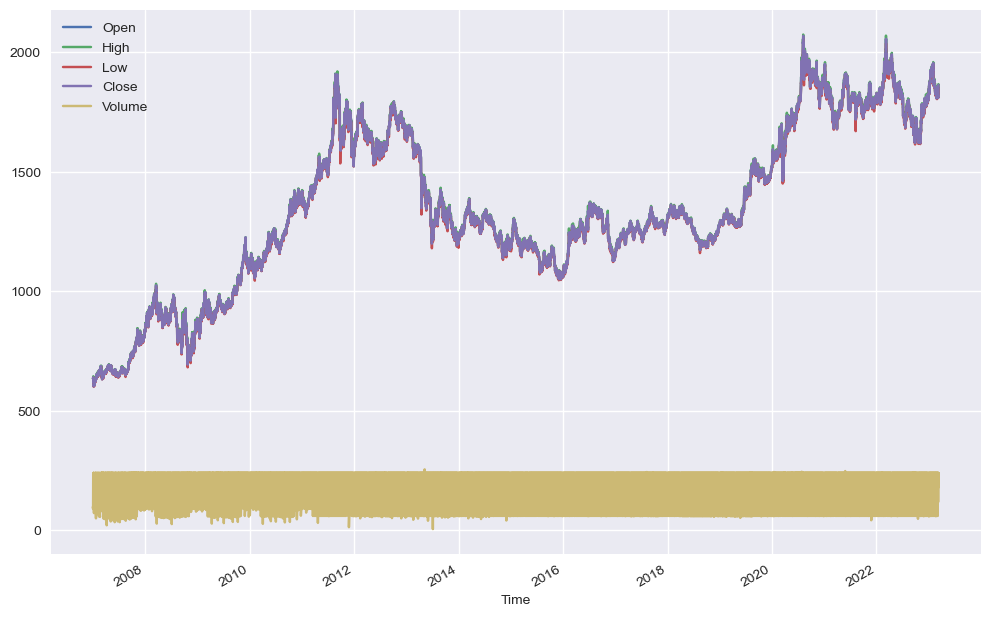

In [35]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [8]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [9]:
mainFolder = 'Machine_Learning'
strategy = Mutiple_Regression
strategyName = 'Mutiple_Regression'
account_size = 10000
folder_ML_Strategy = 'Mutiple_Linear_Regression'
subFolder = 'Optimization'

In [10]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data['returns_signal'] = data['returns'].shift(-1)
        data.dropna(inplace=True)
        cols = []
        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols],
                   rolling_window_data['returns_signal'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100,commission=0.0002)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [39]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'D1'

### Window size 1 year

In [40]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [41]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [42]:
test = ml.Run()

In [43]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   94.976172
Equity Final [$]                     1508.381
Equity Peak [$]                      1601.833
Return [%]                            50.8381
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    2.078115
Volatility (Ann.) [%]               31.967954
Sharpe Ratio                         0.065006
Sortino Ratio                         0.09796
Calmar Ratio                         0.023786
Max. Drawdown [%]                  -87.368241
Avg. Drawdown [%]                   -8.347921
Max. Drawdown Duration     3345 days 00:00:00
Avg. Drawdown Duration      180 days 00:00:00
# Trades                                 2032
Win Rate [%]                        50.885827
Best Trade [%]                       9.290183
Worst Trade [%]                    -11.057102
Avg. Trade [%]                    

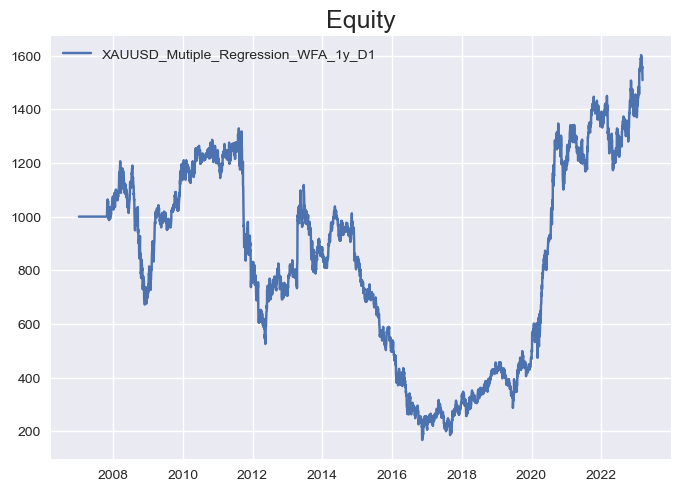

In [44]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [45]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [46]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [47]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [48]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [49]:
test = ml.Run()

In [50]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                     89.9722
Equity Final [$]                     1850.175
Equity Peak [$]                      2435.753
Return [%]                            85.0175
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                    3.126731
Volatility (Ann.) [%]               14.565696
Sharpe Ratio                         0.214664
Sortino Ratio                         0.31883
Calmar Ratio                         0.080976
Max. Drawdown [%]                  -38.612972
Avg. Drawdown [%]                   -4.760502
Max. Drawdown Duration     2547 days 00:00:00
Avg. Drawdown Duration       97 days 00:00:00
# Trades                                 1799
Win Rate [%]                         50.86159
Best Trade [%]                       9.290183
Worst Trade [%]                    -10.973351
Avg. Trade [%]                    

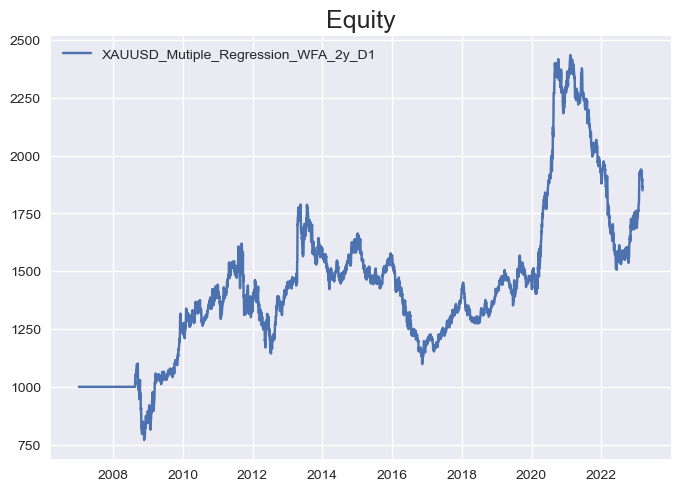

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [52]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [53]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [54]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [55]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [56]:
test = ml.Run()

In [57]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   84.968229
Equity Final [$]                      584.632
Equity Peak [$]                      1691.907
Return [%]                           -41.5368
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -2.650243
Volatility (Ann.) [%]                24.85628
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -79.062856
Avg. Drawdown [%]                   -4.533577
Max. Drawdown Duration     4201 days 00:00:00
Avg. Drawdown Duration      128 days 00:00:00
# Trades                                 1561
Win Rate [%]                        49.391416
Best Trade [%]                       9.290183
Worst Trade [%]                    -14.830592
Avg. Trade [%]                    

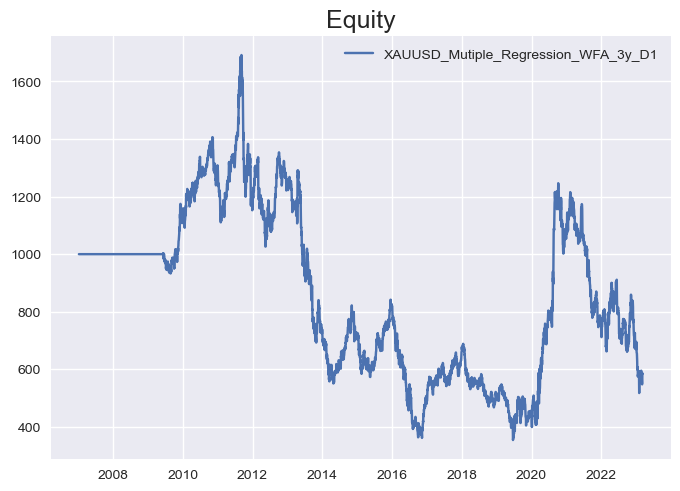

In [58]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [59]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [60]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [61]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [62]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [63]:
test = ml.Run()

In [64]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   22.597299
Equity Final [$]                          0.0
Equity Peak [$]                      1406.424
Return [%]                             -100.0
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               81.845934
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                   -9.638862
Max. Drawdown Duration     4204 days 00:00:00
Avg. Drawdown Duration      262 days 00:00:00
# Trades                                  322
Win Rate [%]                        44.720497
Best Trade [%]                       7.505335
Worst Trade [%]                    -12.217034
Avg. Trade [%]                    

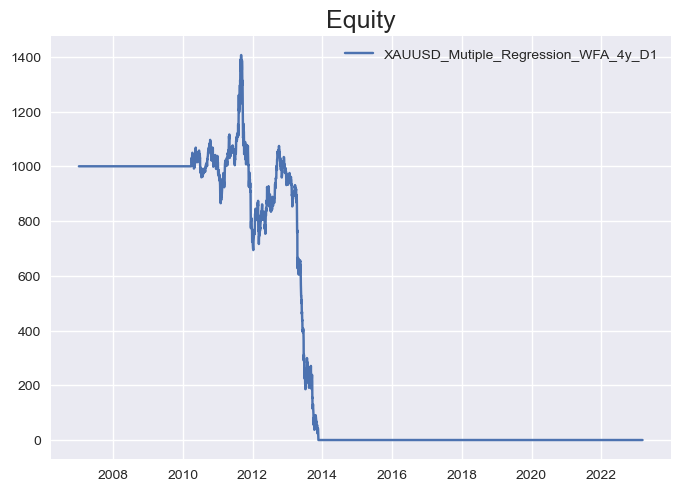

In [65]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [66]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [67]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [68]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [69]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [70]:
test = ml.Run()

In [71]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   26.191422
Equity Final [$]                        8.968
Equity Peak [$]                      1347.502
Return [%]                           -99.1032
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -21.01339
Volatility (Ann.) [%]               38.310593
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.334992
Avg. Drawdown [%]                  -10.209182
Max. Drawdown Duration     3815 days 00:00:00
Avg. Drawdown Duration      222 days 00:00:00
# Trades                                  487
Win Rate [%]                        47.022587
Best Trade [%]                       6.380402
Worst Trade [%]                    -13.511188
Avg. Trade [%]                    

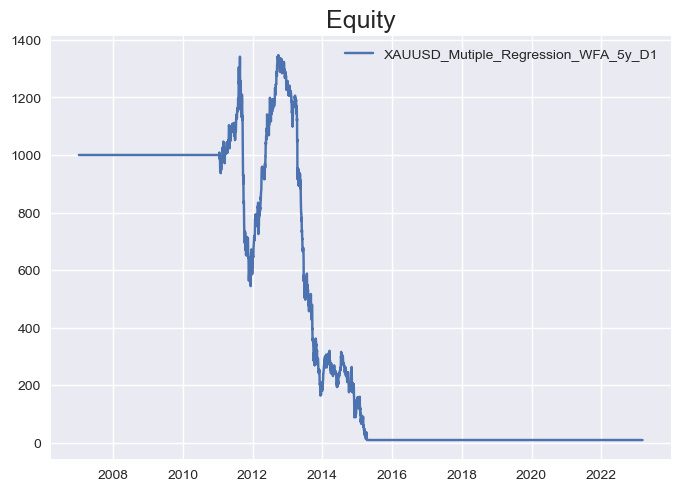

In [72]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [73]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [74]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [75]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [76]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [77]:
test = ml.Run()

In [78]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   69.956315
Equity Final [$]                      940.024
Equity Peak [$]                      1486.535
Return [%]                            -5.9976
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -0.309017
Volatility (Ann.) [%]               20.485408
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -72.856461
Avg. Drawdown [%]                   -7.293057
Max. Drawdown Duration     2911 days 00:00:00
Avg. Drawdown Duration      165 days 00:00:00
# Trades                                 1420
Win Rate [%]                        52.253521
Best Trade [%]                       6.215109
Worst Trade [%]                    -13.511188
Avg. Trade [%]                    

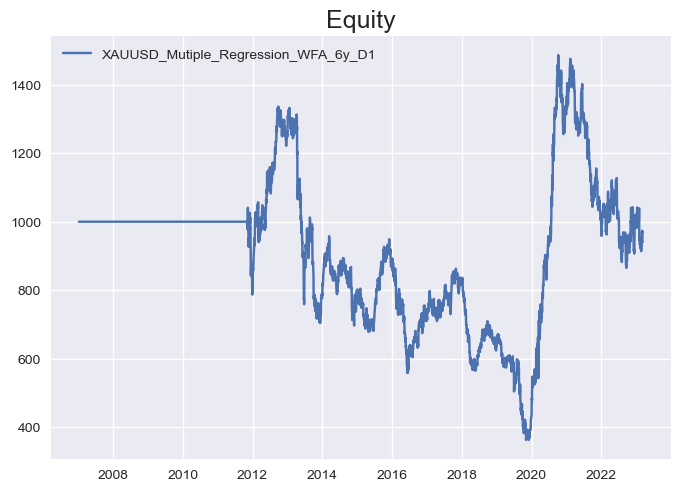

In [79]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [80]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [81]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [82]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [83]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [84]:
test = ml.Run()

In [85]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   23.212867
Equity Final [$]                          0.0
Equity Peak [$]                      1138.091
Return [%]                             -100.0
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]               97.092297
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -17.243747
Max. Drawdown Duration     3815 days 00:00:00
Avg. Drawdown Duration      639 days 00:00:00
# Trades                                  466
Win Rate [%]                        48.283262
Best Trade [%]                       5.285647
Worst Trade [%]                    -13.511188
Avg. Trade [%]                    

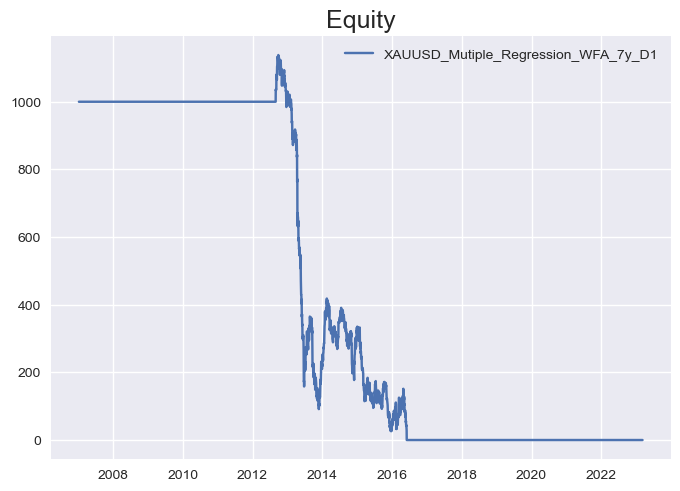

In [86]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [87]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [88]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [89]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [90]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [91]:
test = ml.Run()

In [92]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-09 00:00:00
Duration                   5904 days 00:00:00
Exposure Time [%]                   59.948372
Equity Final [$]                      849.202
Equity Peak [$]                       1321.87
Return [%]                           -15.0798
Buy & Hold Return [%]              200.664234
Return (Ann.) [%]                   -0.814604
Volatility (Ann.) [%]               16.758786
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -57.774077
Avg. Drawdown [%]                  -13.844897
Max. Drawdown Duration     2117 days 00:00:00
Avg. Drawdown Duration      272 days 00:00:00
# Trades                                 1395
Win Rate [%]                        51.541219
Best Trade [%]                       5.873167
Worst Trade [%]                     -7.732588
Avg. Trade [%]                    

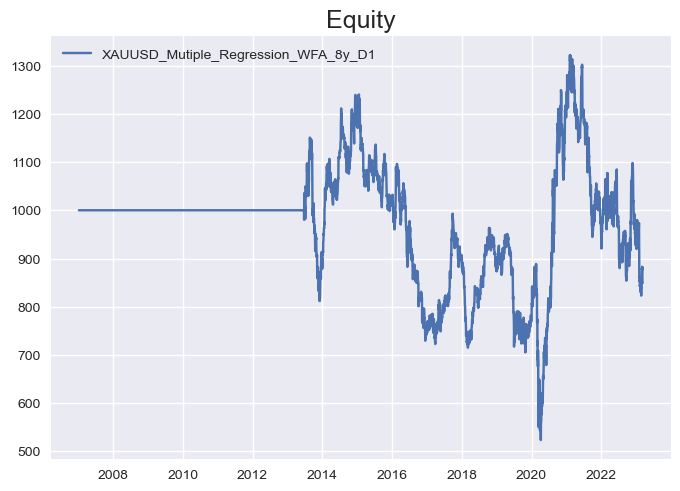

In [93]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [94]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [95]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [96]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H4'

### Window size 1 year

In [97]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [98]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [99]:
test = ml.Run()

In [100]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   94.173823
Equity Final [$]                     3571.381
Equity Peak [$]                      3995.106
Return [%]                           257.1381
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    6.568989
Volatility (Ann.) [%]                9.027967
Sharpe Ratio                         0.727627
Sortino Ratio                        1.178333
Calmar Ratio                         0.489784
Max. Drawdown [%]                   -13.41201
Avg. Drawdown [%]                   -0.965777
Max. Drawdown Duration     1068 days 08:00:00
Avg. Drawdown Duration       14 days 16:00:00
# Trades                                10865
Win Rate [%]                        51.698113
Best Trade [%]                      11.726773
Worst Trade [%]                      -6.53863
Avg. Trade [%]                    

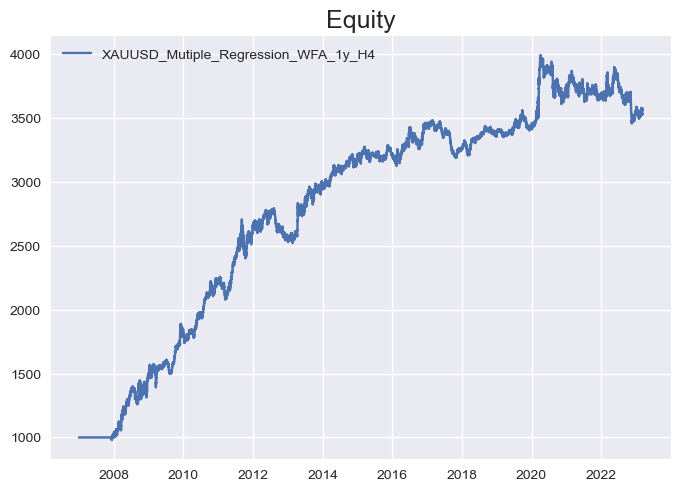

In [101]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [102]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [103]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [104]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [105]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [106]:
test = ml.Run()

In [107]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   88.351496
Equity Final [$]                      2386.83
Equity Peak [$]                      3150.964
Return [%]                            138.683
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                     4.44402
Volatility (Ann.) [%]                9.081789
Sharpe Ratio                         0.489333
Sortino Ratio                        0.749651
Calmar Ratio                         0.158457
Max. Drawdown [%]                  -28.045639
Avg. Drawdown [%]                   -0.917847
Max. Drawdown Duration     3041 days 08:00:00
Avg. Drawdown Duration       17 days 05:00:00
# Trades                                 9981
Win Rate [%]                        51.377617
Best Trade [%]                      10.228327
Worst Trade [%]                     -6.253184
Avg. Trade [%]                    

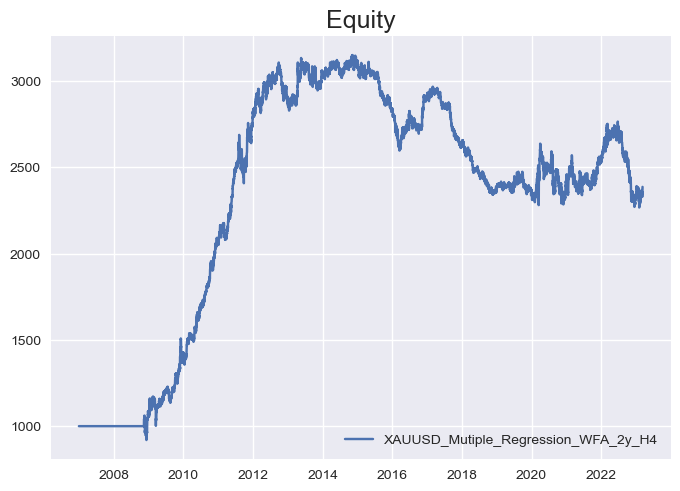

In [108]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [109]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [110]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [111]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [112]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [113]:
test = ml.Run()

In [114]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   82.529169
Equity Final [$]                     2142.791
Equity Peak [$]                      2838.268
Return [%]                           114.2791
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    3.882508
Volatility (Ann.) [%]                8.999355
Sharpe Ratio                         0.431421
Sortino Ratio                        0.656853
Calmar Ratio                         0.135609
Max. Drawdown [%]                  -28.630172
Avg. Drawdown [%]                   -0.909775
Max. Drawdown Duration     2200 days 16:00:00
Avg. Drawdown Duration       17 days 06:00:00
# Trades                                 8866
Win Rate [%]                        51.849763
Best Trade [%]                       8.698871
Worst Trade [%]                     -5.711377
Avg. Trade [%]                    

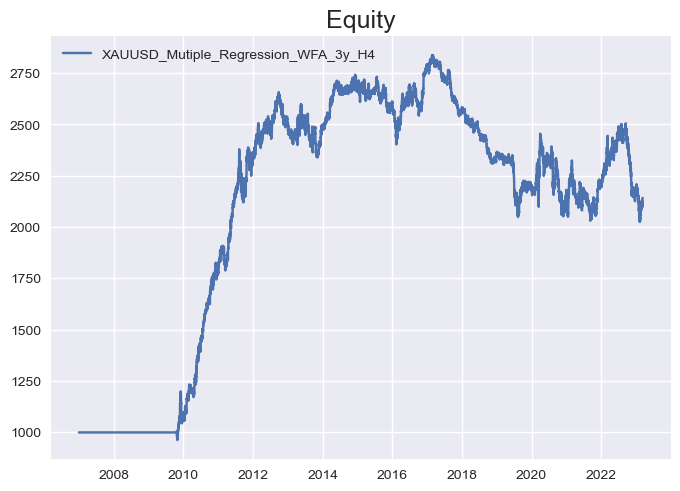

In [115]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [116]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [117]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [118]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [119]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [120]:
test = ml.Run()

In [121]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   76.706843
Equity Final [$]                     1910.145
Equity Peak [$]                      2536.063
Return [%]                            91.0145
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    3.287494
Volatility (Ann.) [%]                9.761319
Sharpe Ratio                         0.336788
Sortino Ratio                        0.515043
Calmar Ratio                         0.098107
Max. Drawdown [%]                  -33.509183
Avg. Drawdown [%]                   -1.293935
Max. Drawdown Duration     3851 days 00:00:00
Avg. Drawdown Duration       27 days 16:00:00
# Trades                                 8368
Win Rate [%]                        52.174952
Best Trade [%]                       7.315825
Worst Trade [%]                     -6.302795
Avg. Trade [%]                    

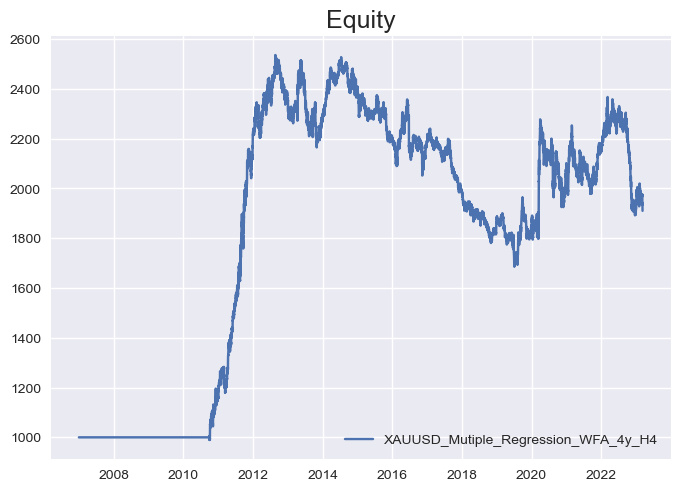

In [122]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [123]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [124]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [125]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [126]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, 500)

In [127]:
test = ml.Run()

In [128]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   70.884516
Equity Final [$]                     1315.532
Equity Peak [$]                      1700.325
Return [%]                           163.1064
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    4.953817
Volatility (Ann.) [%]               16.212327
Sharpe Ratio                         0.305559
Sortino Ratio                        0.495035
Calmar Ratio                         0.139075
Max. Drawdown [%]                   -35.61978
Avg. Drawdown [%]                   -3.030938
Max. Drawdown Duration     2107 days 08:00:00
Avg. Drawdown Duration       38 days 18:00:00
# Trades                                 7835
Win Rate [%]                        51.920868
Best Trade [%]                       5.396469
Worst Trade [%]                     -5.711377
Avg. Trade [%]                    

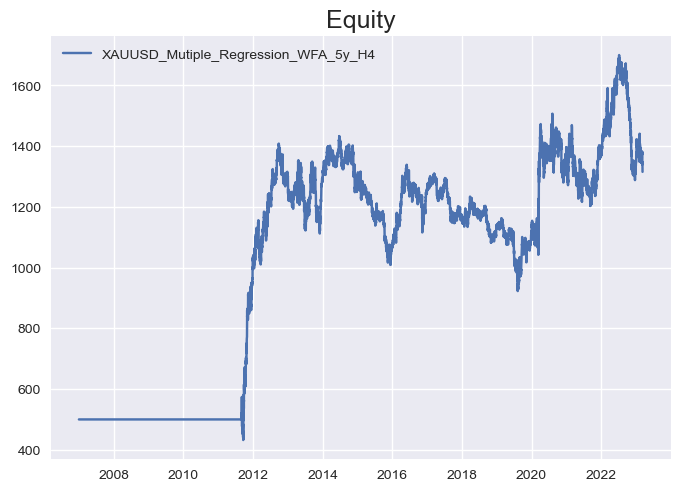

In [129]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [130]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [131]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [132]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [133]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [134]:
test = ml.Run()

In [135]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                    65.06219
Equity Final [$]                     1041.031
Equity Peak [$]                      1458.435
Return [%]                             4.1031
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                     0.20118
Volatility (Ann.) [%]               15.506411
Sharpe Ratio                         0.012974
Sortino Ratio                        0.018679
Calmar Ratio                         0.004998
Max. Drawdown [%]                    -40.2537
Avg. Drawdown [%]                   -3.511125
Max. Drawdown Duration     2223 days 08:00:00
Avg. Drawdown Duration       72 days 15:00:00
# Trades                                 7230
Win Rate [%]                        51.051176
Best Trade [%]                       5.396469
Worst Trade [%]                     -5.711377
Avg. Trade [%]                    

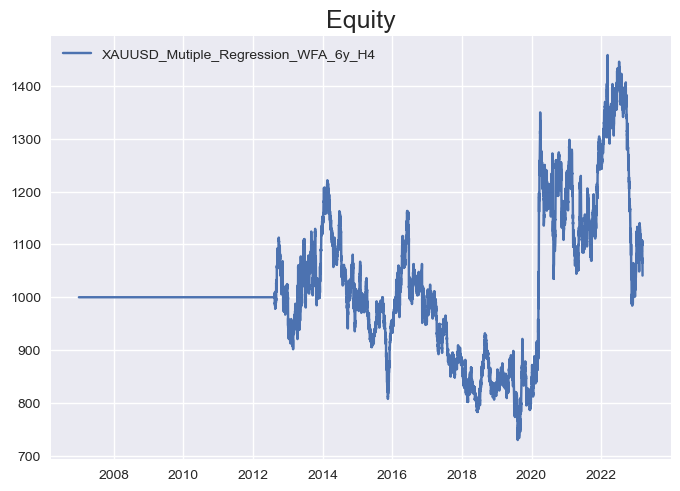

In [136]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [137]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [138]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [139]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [140]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [141]:
test = ml.Run()

In [142]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   59.239863
Equity Final [$]                     1271.187
Equity Peak [$]                      1943.196
Return [%]                            27.1187
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                      1.2065
Volatility (Ann.) [%]               10.919752
Sharpe Ratio                         0.110488
Sortino Ratio                        0.157117
Calmar Ratio                         0.034887
Max. Drawdown [%]                  -34.582667
Avg. Drawdown [%]                   -2.144498
Max. Drawdown Duration      794 days 00:00:00
Avg. Drawdown Duration       32 days 14:00:00
# Trades                                 6579
Win Rate [%]                        51.968384
Best Trade [%]                        3.88597
Worst Trade [%]                     -5.711377
Avg. Trade [%]                    

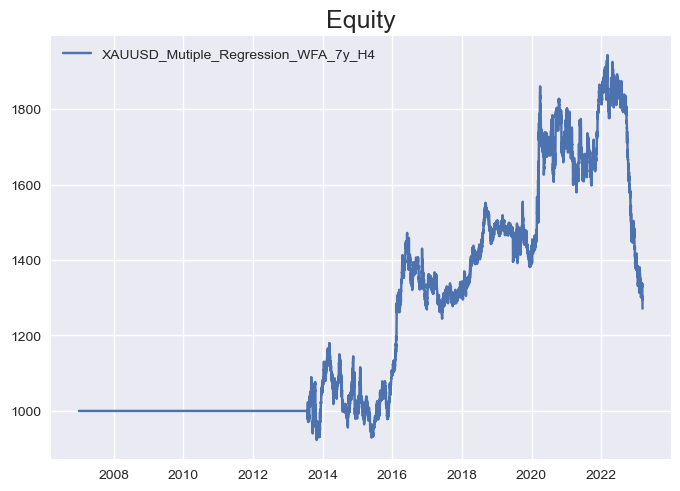

In [143]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [144]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [145]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [146]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [147]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [148]:
test = ml.Run()

In [149]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   53.417536
Equity Final [$]                      393.243
Equity Peak [$]                      1228.336
Return [%]                           -60.6757
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -4.557658
Volatility (Ann.) [%]               17.162217
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -69.533825
Avg. Drawdown [%]                   -4.427571
Max. Drawdown Duration     1870 days 12:00:00
Avg. Drawdown Duration       87 days 20:00:00
# Trades                                 6027
Win Rate [%]                        51.302472
Best Trade [%]                        5.73108
Worst Trade [%]                     -5.572428
Avg. Trade [%]                    

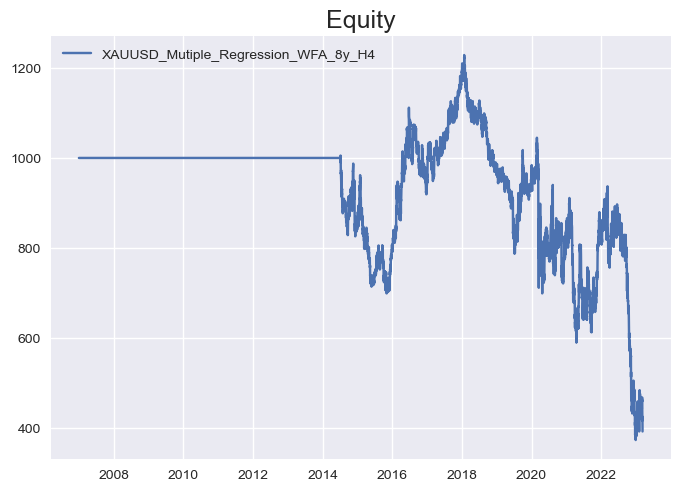

In [150]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [151]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [152]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [153]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'H1'

### Window size 1 year

In [154]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [155]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [156]:
test = ml.Run()

In [157]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   93.824211
Equity Final [$]                      1464.92
Equity Peak [$]                      1998.615
Return [%]                             46.492
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    1.926184
Volatility (Ann.) [%]               16.159554
Sharpe Ratio                         0.119198
Sortino Ratio                        0.174993
Calmar Ratio                         0.036174
Max. Drawdown [%]                  -53.248274
Avg. Drawdown [%]                   -1.068174
Max. Drawdown Duration     3605 days 15:00:00
Avg. Drawdown Duration       22 days 07:00:00
# Trades                                43590
Win Rate [%]                        51.479697
Best Trade [%]                       7.231451
Worst Trade [%]                     -4.493033
Avg. Trade [%]                    

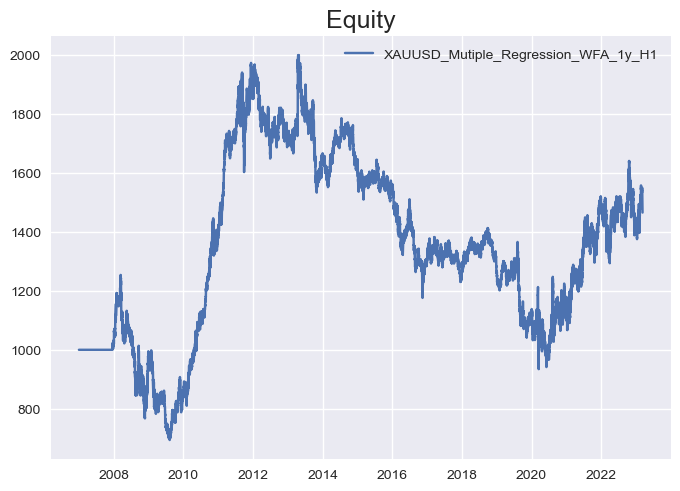

In [158]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [159]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [160]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [161]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [162]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [163]:
test = ml.Run()

In [164]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                     2260.671
Equity Peak [$]                      2356.849
Return [%]                           126.0671
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.160086
Volatility (Ann.) [%]               13.838776
Sharpe Ratio                         0.300611
Sortino Ratio                        0.450026
Calmar Ratio                         0.115534
Max. Drawdown [%]                  -36.007506
Avg. Drawdown [%]                   -0.789412
Max. Drawdown Duration     3644 days 04:00:00
Avg. Drawdown Duration       14 days 22:00:00
# Trades                                40402
Win Rate [%]                        51.341518
Best Trade [%]                       6.257703
Worst Trade [%]                      -4.64747
Avg. Trade [%]                    

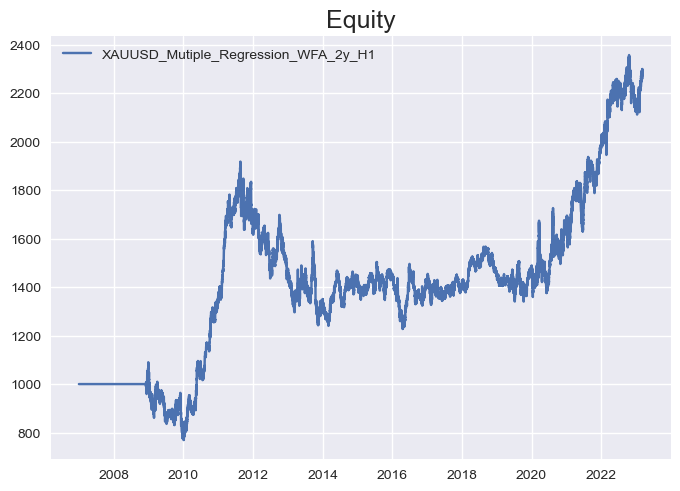

In [165]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [166]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [167]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [168]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [169]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [170]:
test = ml.Run()

In [171]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2479.273
Equity Peak [$]                      2517.077
Return [%]                           147.9273
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.641628
Volatility (Ann.) [%]               11.590979
Sharpe Ratio                         0.400452
Sortino Ratio                        0.600243
Calmar Ratio                         0.155495
Max. Drawdown [%]                  -29.850623
Avg. Drawdown [%]                   -0.907917
Max. Drawdown Duration     3104 days 11:00:00
Avg. Drawdown Duration       14 days 09:00:00
# Trades                                36879
Win Rate [%]                        50.611459
Best Trade [%]                       5.205037
Worst Trade [%]                     -5.177281
Avg. Trade [%]                    

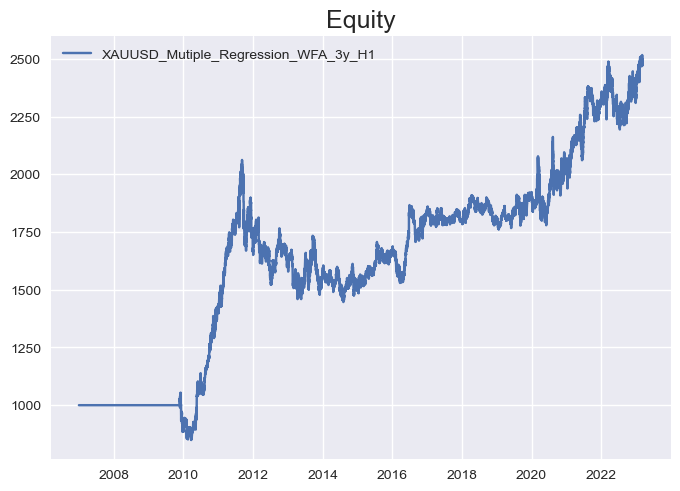

In [172]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [173]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [174]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [175]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [176]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [177]:
test = ml.Run()

In [178]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   75.299907
Equity Final [$]                     1528.897
Equity Peak [$]                      1680.418
Return [%]                            52.8897
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    2.144133
Volatility (Ann.) [%]               14.950164
Sharpe Ratio                         0.143419
Sortino Ratio                        0.206428
Calmar Ratio                         0.045255
Max. Drawdown [%]                  -47.379343
Avg. Drawdown [%]                   -1.193058
Max. Drawdown Duration     4200 days 17:00:00
Avg. Drawdown Duration       29 days 19:00:00
# Trades                                34133
Win Rate [%]                        50.587408
Best Trade [%]                       3.636044
Worst Trade [%]                     -4.506799
Avg. Trade [%]                    

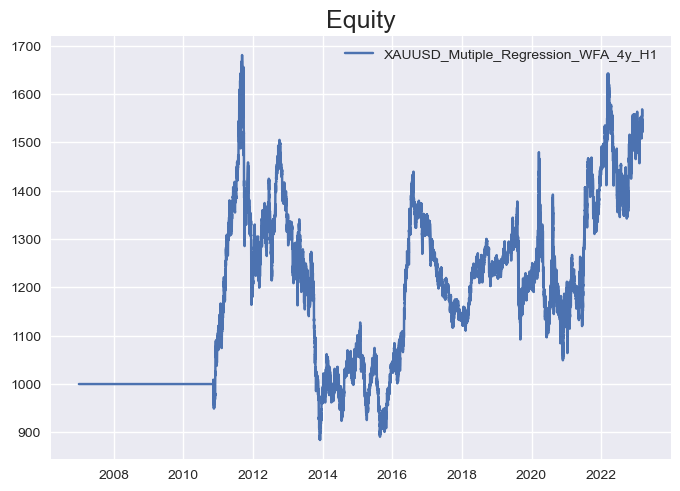

In [179]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [180]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [181]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [182]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [183]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [184]:
test = ml.Run()

In [185]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   69.125139
Equity Final [$]                      748.213
Equity Peak [$]                      1105.849
Return [%]                           -25.1787
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                   -1.439021
Volatility (Ann.) [%]               49.358442
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -94.83944
Avg. Drawdown [%]                   -7.169292
Max. Drawdown Duration     3808 days 15:00:00
Avg. Drawdown Duration      207 days 10:00:00
# Trades                                30417
Win Rate [%]                        50.251504
Best Trade [%]                       4.029631
Worst Trade [%]                     -6.893186
Avg. Trade [%]                    

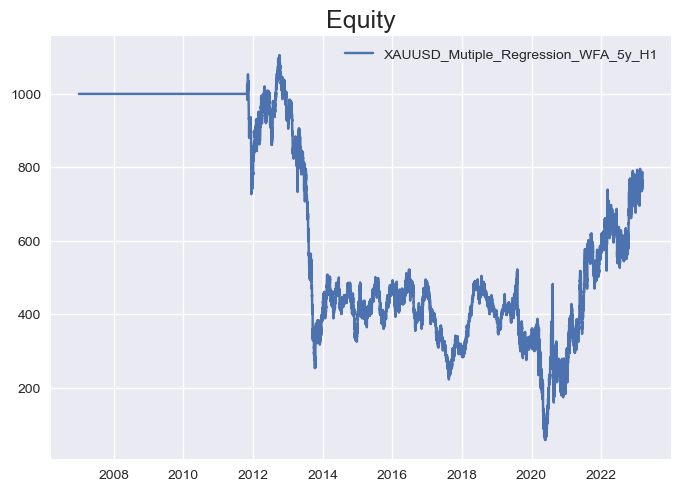

In [186]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [187]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [188]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [189]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [190]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [191]:
test = ml.Run()

In [192]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   44.831388
Equity Final [$]                       12.124
Equity Peak [$]                      1025.807
Return [%]                           -98.7876
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                  -19.788009
Volatility (Ann.) [%]                27.35342
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.897356
Avg. Drawdown [%]                  -11.001802
Max. Drawdown Duration     3759 days 01:00:00
Avg. Drawdown Duration      378 days 11:00:00
# Trades                                19349
Win Rate [%]                        48.705359
Best Trade [%]                       4.029631
Worst Trade [%]                      -4.04148
Avg. Trade [%]                    

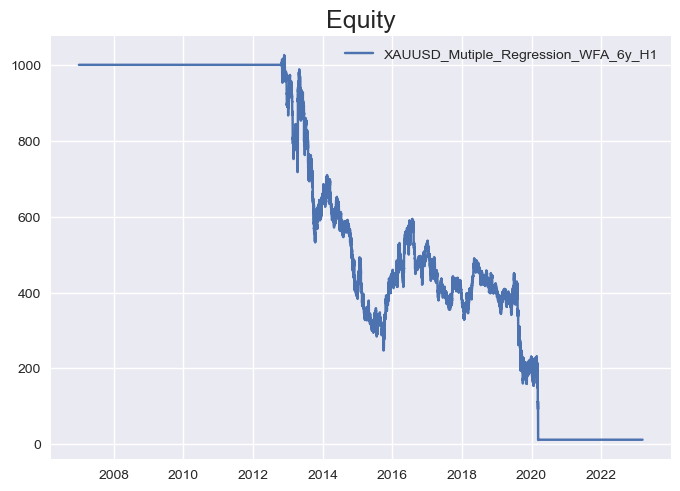

In [193]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [194]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [195]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [196]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [197]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [198]:
test = ml.Run()

In [199]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   41.045668
Equity Final [$]                        16.11
Equity Peak [$]                      1138.683
Return [%]                            -98.389
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                  -18.640531
Volatility (Ann.) [%]               50.216445
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -98.586086
Avg. Drawdown [%]                   -2.992739
Max. Drawdown Duration     3282 days 21:00:00
Avg. Drawdown Duration       74 days 08:00:00
# Trades                                17865
Win Rate [%]                        48.687378
Best Trade [%]                       4.281275
Worst Trade [%]                     -2.768109
Avg. Trade [%]                    

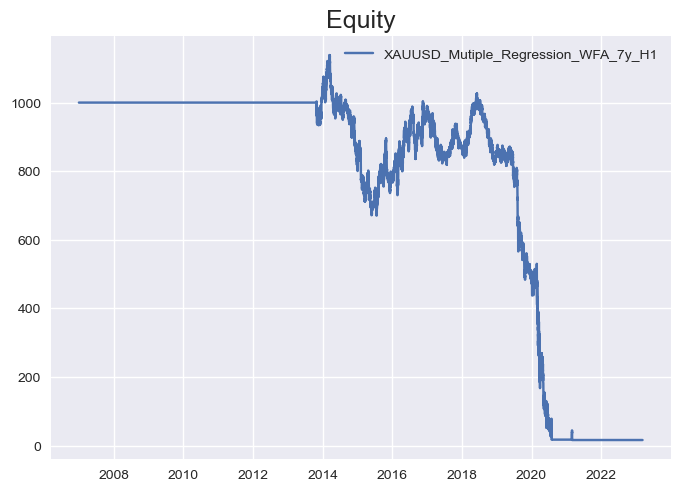

In [200]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [201]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [202]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [203]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [204]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [205]:
test = ml.Run()

In [206]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   50.600835
Equity Final [$]                     1400.088
Equity Peak [$]                      1452.959
Return [%]                            40.0088
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    1.695894
Volatility (Ann.) [%]               16.457931
Sharpe Ratio                         0.103044
Sortino Ratio                        0.151333
Calmar Ratio                          0.03479
Max. Drawdown [%]                  -48.746732
Avg. Drawdown [%]                   -2.073889
Max. Drawdown Duration     1165 days 01:00:00
Avg. Drawdown Duration       26 days 23:00:00
# Trades                                22157
Win Rate [%]                        50.417475
Best Trade [%]                       4.876489
Worst Trade [%]                      -4.34176
Avg. Trade [%]                    

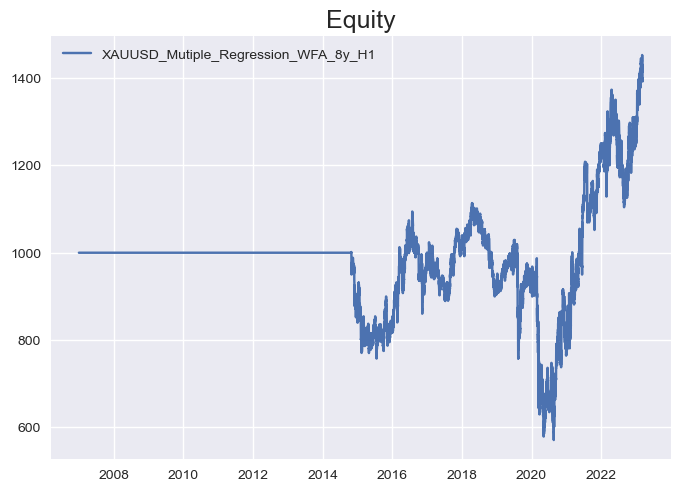

In [207]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [208]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [209]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF M30

In [11]:
start_train = '2007'
end_train = '2023'
account_size = 10000
TF = 'M30'

### Window size 1 year

In [211]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [212]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [213]:
test = ml.Run()

In [214]:
test

Start                     2007-01-01 03:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   93.803719
Equity Final [$]                     2475.269
Equity Peak [$]                      2797.883
Return [%]                           147.5269
Buy & Hold Return [%]              193.089867
Return (Ann.) [%]                    4.633177
Volatility (Ann.) [%]               13.554571
Sharpe Ratio                         0.341817
Sortino Ratio                        0.513124
Calmar Ratio                         0.110118
Max. Drawdown [%]                  -42.074704
Avg. Drawdown [%]                   -0.637662
Max. Drawdown Duration     3478 days 16:00:00
Avg. Drawdown Duration        9 days 05:20:00
# Trades                                85964
Win Rate [%]                        52.638314
Best Trade [%]                       5.176663
Worst Trade [%]                     -4.620434
Avg. Trade [%]                    

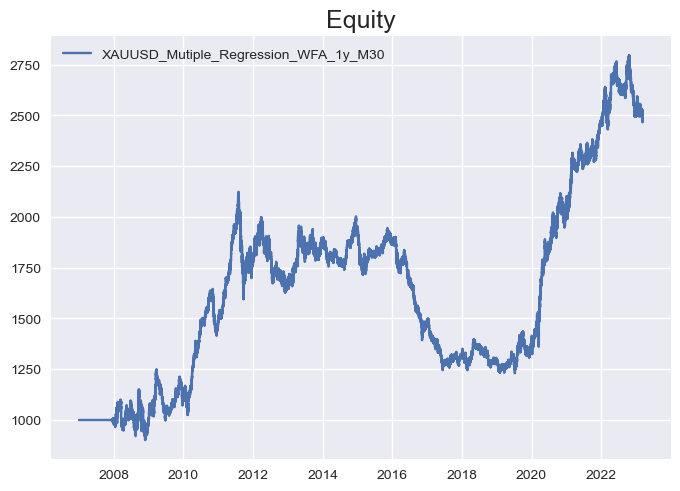

In [215]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [216]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [217]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [12]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [13]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [14]:
test = ml.Run()

In [15]:
test

Start                     2007-01-01 03:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                    87.60795
Equity Final [$]                     2522.008
Equity Peak [$]                      2663.971
Return [%]                           152.2008
Buy & Hold Return [%]              193.089867
Return (Ann.) [%]                     4.73103
Volatility (Ann.) [%]               14.639825
Sharpe Ratio                         0.323162
Sortino Ratio                        0.493485
Calmar Ratio                         0.118474
Max. Drawdown [%]                  -39.933022
Avg. Drawdown [%]                   -0.879343
Max. Drawdown Duration     2545 days 09:30:00
Avg. Drawdown Duration       11 days 06:54:00
# Trades                                81414
Win Rate [%]                        53.108802
Best Trade [%]                        4.50498
Worst Trade [%]                     -4.620434
Avg. Trade [%]                    

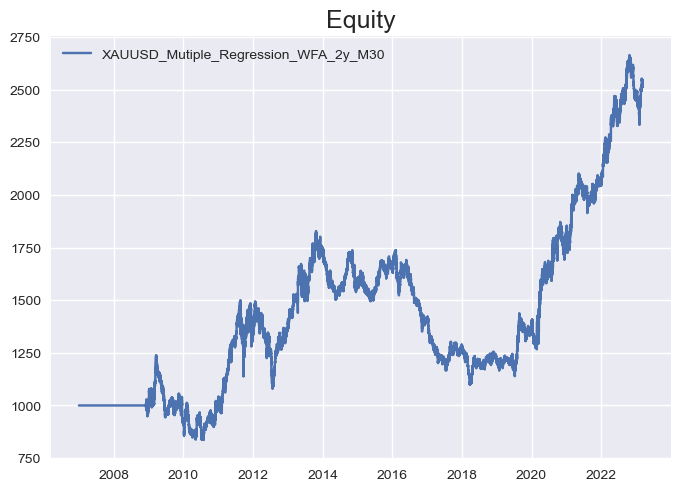

In [16]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [17]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [18]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [19]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [20]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [21]:
test = ml.Run()

In [22]:
test

Start                     2007-01-01 03:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 14:00:00
Exposure Time [%]                   81.412181
Equity Final [$]                     1539.789
Equity Peak [$]                      1712.118
Return [%]                            53.9789
Buy & Hold Return [%]              193.089867
Return (Ann.) [%]                    2.180373
Volatility (Ann.) [%]               29.037554
Sharpe Ratio                         0.075088
Sortino Ratio                        0.113393
Calmar Ratio                         0.026279
Max. Drawdown [%]                  -82.970071
Avg. Drawdown [%]                   -1.671677
Max. Drawdown Duration     2892 days 12:30:00
Avg. Drawdown Duration       21 days 20:25:00
# Trades                                78100
Win Rate [%]                        53.480154
Best Trade [%]                       2.845167
Worst Trade [%]                     -5.181214
Avg. Trade [%]                    

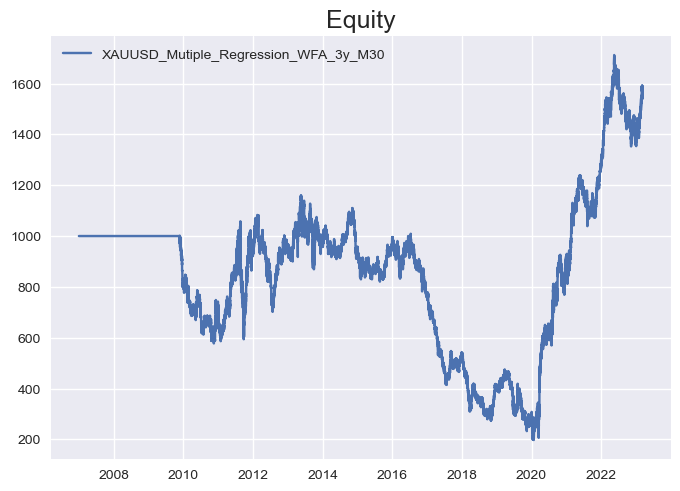

In [23]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [24]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [25]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [26]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [27]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [28]:
test = ml.Run()

KeyboardInterrupt: 

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48 
WFA = '7y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data,strategy,start_train,end_train,TF,window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')